# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1741]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
%matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
# transcript = pd.read_json('transcript.json', orient='records', lines=True)
transcript=pd.read_csv('transcript_expanded.csv')

Data Exploration

In [1742]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [1743]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [1744]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


Data Cleaning
1. extract different values from transcript into different columns.
2. offer_id into offer id

In [1833]:
#expand value column in transcript
# transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
# transcript.to_csv('transcript_expanded.csv',index=False)

transcript=pd.read_csv('transcript_expanded.csv')

In [1834]:
#create new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [1918]:
portfolio.rename(columns={'id':'offer_id'},inplace=True)

In [1836]:
transcript=transcript.merge(portfolio,how='left',on='offer_id')

In [1837]:
transcript['day_offer']=transcript['time']/24

In [1838]:
transcript=transcript.sort_values(['person','day_offer'])

In [1839]:
transcript=drop_cols(['value','time','reward_y'],transcript)

In [1847]:
transcript.head()

,event,person,amount,reward_x,offer_id,channels,difficulty,duration,offer_type,day_offer
55972,offer received,0009655768c64bdeb2e877511632db8f,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,7.0
77705,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,8.0
89291,transaction,0009655768c64bdeb2e877511632db8f,22.16,NaN,NaN,NaN,NaN,NaN,NaN,9.5
113605,offer received,0009655768c64bdeb2e877511632db8f,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,14.0
139992,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,15.5


In [1958]:
offers_view_transacted2=transcript[['day_offer','offer_id','person','event']][(transcript['event']=='transaction') | (transcript['event']=='offer viewed')].groupby('person').ffill()

In [1959]:
transactions_clean=transcript.merge(offers_view_transacted2,how='left',on=['person','day_offer','event'])

In [1960]:
transactions_clean['offer_id']=np.where(transactions_clean['offer_id_x'].isnull(),transactions_clean['offer_id_y'],transactions_clean['offer_id_x'])

transactions_clean=drop_cols(['offer_id_x','offer_id_y'],transactions_clean)

In [1961]:
transactions_clean=transactions_clean.merge(portfolio,how='left',on='offer_id')

In [1962]:
transactions_clean.columns

Index(['event', 'person', 'amount', 'reward_x', 'channels_x', 'difficulty_x',
       'duration_x', 'offer_type_x', 'day_offer', 'offer_id', 'channels_y',
       'difficulty_y', 'duration_y', 'offer_type_y', 'reward'],
      dtype='object')

In [1963]:
transactions_clean['duration']=np.where(transactions_clean['duration_x'].isnull(),transactions_clean['duration_y'],transactions_clean['duration_x'])

In [1964]:
transactions_clean=drop_cols(['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],transactions_clean)

In [1965]:
transactions_clean.rename(columns={'channels_y':'channels','reward_x':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)

In [1995]:
transactions_clean['diff_bogo']=transactions_clean.sort_values(['person','day_offer','offer_id'])[(transactions_clean['offer_type']=='bogo') & (transactions_clean['event']=='offer viewed') | (transactions_clean['event']=='offer completed') |(transactions_clean['event']=='transaction')].groupby(['person','offer_id'])['day_offer'].diff()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [2014]:
transactions_clean['previous']=transactions_clean.sort_values(['person','day_offer','offer_id']).groupby(['person','offer_id'])['event'].shift()

In [2016]:
transactions_clean['previous_day_offer']=transactions_clean.sort_values(['person','day_offer','offer_id']).groupby(['person','offer_id'])['day_offer'].shift()

In [2027]:
transactions_clean['previous_2']=transactions_clean.sort_values(['person','day_offer','offer_id']).groupby(['person','offer_id'])['event'].shift(2)

In [2055]:
transactions_clean['previous_3']=transactions_clean.sort_values(['person','day_offer','offer_id']).groupby(['person','offer_id'])['event'].shift(3)

In [2057]:
transactions_clean['previous_4']=transactions_clean.sort_values(['person','day_offer','offer_id']).groupby(['person','offer_id'])['event'].shift(4)

In [2059]:
transactions_clean['previous_5']=transactions_clean.sort_values(['person','day_offer','offer_id']).groupby(['person','offer_id'])['event'].shift(5)

In [2060]:
transactions_clean['previous_6']=transactions_clean.sort_values(['person','day_offer','offer_id']).groupby(['person','offer_id'])['event'].shift(6)

In [2062]:
transactions_clean['previous_7']=transactions_clean.sort_values(['person','day_offer','offer_id']).groupby(['person','offer_id'])['event'].shift(7)

KeyboardInterrupt: 

In [1981]:
transactions_clean['diff']=transactions_clean.sort_values(['person','day_offer','offer_id'])[(transactions_clean['event']=='offer viewed') |(transactions_clean['event']=='offer completed')].groupby(['person','offer_id'])['day_offer'].diff()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [1982]:
transactions_clean['valid_completed']=np.where(transactions_clean['diff']<=transactions_clean['duration'],1,0)

In [1983]:
transactions_clean['diff_info']=transactions_clean.sort_values(['person','day_offer','offer_id'])[(transactions_clean['offer_type']=='informational') & (transactions_clean['event']=='offer viewed') | (transactions_clean['event']=='transaction')].groupby(['person','offer_id'])['day_offer'].diff()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [1984]:
transactions_clean.loc[transactions_clean['diff_info']<=transactions_clean['duration'],'valid_completed']=1

In [1993]:
transactions_clean[['person','day_offer','event','offer_id','valid_completed','offer_type','diff']]

,person,day_offer,event,offer_id,valid_completed,offer_type,diff
0,0009655768c64bdeb2e877511632db8f,7.00,offer received,5a8bc65990b245e5a138643cd4eb9837,0,informational,NaN
1,0009655768c64bdeb2e877511632db8f,8.00,offer viewed,5a8bc65990b245e5a138643cd4eb9837,0,informational,NaN
2,0009655768c64bdeb2e877511632db8f,9.50,transaction,5a8bc65990b245e5a138643cd4eb9837,1,informational,NaN
3,0009655768c64bdeb2e877511632db8f,14.00,offer received,3f207df678b143eea3cee63160fa8bed,0,informational,NaN
4,0009655768c64bdeb2e877511632db8f,15.50,offer viewed,3f207df678b143eea3cee63160fa8bed,0,informational,NaN
5,0009655768c64bdeb2e877511632db8f,17.00,offer received,f19421c1d4aa40978ebb69ca19b0e20d,0,bogo,NaN
6,0009655768c64bdeb2e877511632db8f,17.25,transaction,3f207df678b143eea3cee63160fa8bed,1,informational,NaN
7,0009655768c64bdeb2e877511632db8f,17.25,offer completed,f19421c1d4aa40978ebb69ca19b0e20d,0,bogo,NaN
8,0009655768c64bdeb2e877511632db8f,19.00,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d,1,bogo,1.75
9,0009655768c64bdeb2e877511632db8f,21.00,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,discount,NaN


In [1747]:
transcript_events=pd.DataFrame(transcript.sort_values('time').groupby(['person','time','event','offer_id']).count()['value']).reset_index()

In [1748]:
df=transcript_events.pivot_table(index=['offer_id','person','time','event'])

In [1749]:
df2=df.unstack().reset_index().groupby(['offer_id','person']).sum()

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [1750]:
df2.reset_index(inplace=True)

In [1751]:
df2.columns=['offer_id','person','time','offer_completed','offer_received','offer_viewed']

In [1752]:
df2.drop(['time'],axis=1,inplace=True)

In [1753]:
df2['effective_offer']=np.where((df2['offer_completed']>=1.0) & (df2['offer_viewed']>=1.0),1,0)

In [1754]:
df2.head()

,offer_id,person,offer_completed,offer_received,offer_viewed,effective_offer
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,1.0,1
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,003d66b6608740288d6cc97a6903f4f0,1.0,1.0,0.0,0
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,00426fe3ffde4c6b9cb9ad6d077a13ea,0.0,1.0,0.0,0
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,0056df74b63b4298809f0b375a304cf4,1.0,1.0,0.0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,0063def0f9c14bc4805322a488839b32,0.0,1.0,1.0,0


In [1755]:
amounts=transcript.groupby(['person','time','amount']).sum().reset_index()

In [1756]:
events=transcript.groupby(['person','time','event','offer_id']).sum().reset_index()

In [1757]:
drop_cols('reward',amounts)
drop_cols(['amount','reward'],events)

,person,time,event,offer_id
0,0009655768c64bdeb2e877511632db8f,168,offer received,5a8bc65990b245e5a138643cd4eb9837
1,0009655768c64bdeb2e877511632db8f,192,offer viewed,5a8bc65990b245e5a138643cd4eb9837
2,0009655768c64bdeb2e877511632db8f,336,offer received,3f207df678b143eea3cee63160fa8bed
3,0009655768c64bdeb2e877511632db8f,372,offer viewed,3f207df678b143eea3cee63160fa8bed
4,0009655768c64bdeb2e877511632db8f,408,offer received,f19421c1d4aa40978ebb69ca19b0e20d
5,0009655768c64bdeb2e877511632db8f,414,offer completed,f19421c1d4aa40978ebb69ca19b0e20d
6,0009655768c64bdeb2e877511632db8f,456,offer viewed,f19421c1d4aa40978ebb69ca19b0e20d
7,0009655768c64bdeb2e877511632db8f,504,offer received,fafdcd668e3743c1bb461111dcafc2a4
8,0009655768c64bdeb2e877511632db8f,528,offer completed,fafdcd668e3743c1bb461111dcafc2a4
9,0009655768c64bdeb2e877511632db8f,540,offer viewed,fafdcd668e3743c1bb461111dcafc2a4


In [1758]:
transactions_all=events.append(amounts,sort=True).sort_values(['person','time','offer_id'])

In [1759]:
transactions_all['event'][transactions_all['event'].isnull()]='transaction'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1760]:
offers_view_transacted=transactions_all[['time','offer_id','person','event']][(transactions_all['event']=='transaction') | (transactions_all['event']=='offer viewed')].groupby('person').ffill()

In [1761]:
transactions_all=transactions_all.merge(offers_view_transacted,how='left',on=['person','time','event'])

In [1762]:
transactions_all['offer_id']=np.where(transactions_all['offer_id_x'].isnull(),transactions_all['offer_id_y'],transactions_all['offer_id_x'])

In [1763]:
drop_cols(['offer_id_x','offer_id_y'],transactions_all)

,amount,event,person,time,offer_id
0,NaN,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837
1,NaN,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837
2,22.16,transaction,0009655768c64bdeb2e877511632db8f,228,5a8bc65990b245e5a138643cd4eb9837
3,NaN,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed
4,NaN,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed
5,NaN,offer received,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d
6,NaN,offer completed,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d
7,8.57,transaction,0009655768c64bdeb2e877511632db8f,414,3f207df678b143eea3cee63160fa8bed
8,NaN,offer viewed,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d
9,NaN,offer received,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4


In [1764]:
transactions_all=transactions_all.groupby(['offer_id','person','time','event']).sum().reset_index().sort_values(['person','time'])

In [1765]:
transactions_all=transactions_all.join(pd.get_dummies(transactions_all['event']))

In [1766]:
transactions_all=transactions_all.groupby(['person','offer_id']).sum().reset_index()

In [1767]:
transactions_all.head()

,person,offer_id,time,amount,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1152,0.00,1,1,0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1122,8.57,0,1,1,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,588,22.16,0,1,1,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1806,14.11,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,4746,82.76,1,1,1,5


In [1768]:
transactions_all['effective_offer']=np.where((transactions_all['offer completed']>=1) & (transactions_all['offer viewed']>=1),1,0)

In [1769]:
transactions_all.head()

,person,offer_id,time,amount,offer completed,offer received,offer viewed,transaction,effective_offer
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1152,0.00,1,1,0,0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1122,8.57,0,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,588,22.16,0,1,1,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1806,14.11,1,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,4746,82.76,1,1,1,5,1


In [1770]:
#get people who purchased but did not receive any offers
df3=transcript[np.logical_not(transcript['person'].isin(df2['person']))]

In [1771]:
df3.head()

,event,person,time,value,amount,reward,offer_id
16379,transaction,eb540099db834cf59001f83a4561aef3,6,{'amount': 4.74},4.74,NaN,NaN
22092,transaction,12ede229379747bd8d74ccdc20097ca3,18,{'amount': 16.62},16.62,NaN,NaN
69477,transaction,c6e579c6821c41d1a7a6a9cf936e91bb,174,{'amount': 0.65},0.65,NaN,NaN
87239,transaction,c6e579c6821c41d1a7a6a9cf936e91bb,222,{'amount': 1.9100000000000001},1.91,NaN,NaN
106812,transaction,ae8111e7e8cd4b60a8d35c42c1110555,306,{'amount': 17.51},17.51,NaN,NaN


In [1773]:
profile.rename(columns={'id':'person'},inplace=True)

In [1774]:
offers=transactions_all.merge(portfolio,how='left',on='offer_id')

In [1775]:
offers=offers.merge(profile,how='left',on='person')

In [1776]:
no_offers=df3.merge(profile,how='left',on='person')

In [1777]:
no_offers.head()

,event,person,time,value,amount,reward,offer_id,age,became_member_on,gender,income
0,transaction,eb540099db834cf59001f83a4561aef3,6,{'amount': 4.74},4.74,NaN,NaN,66,20170929,F,34000.0
1,transaction,12ede229379747bd8d74ccdc20097ca3,18,{'amount': 16.62},16.62,NaN,NaN,91,20151005,M,70000.0
2,transaction,c6e579c6821c41d1a7a6a9cf936e91bb,174,{'amount': 0.65},0.65,NaN,NaN,72,20171014,F,35000.0
3,transaction,c6e579c6821c41d1a7a6a9cf936e91bb,222,{'amount': 1.9100000000000001},1.91,NaN,NaN,72,20171014,F,35000.0
4,transaction,ae8111e7e8cd4b60a8d35c42c1110555,306,{'amount': 17.51},17.51,NaN,NaN,54,20170106,F,72000.0


In [1778]:
no_offers.drop(['value','reward','offer_id','event','time'],axis=1,inplace=True)

In [1779]:
no_offers.head()

,person,amount,age,became_member_on,gender,income
0,eb540099db834cf59001f83a4561aef3,4.74,66,20170929,F,34000.0
1,12ede229379747bd8d74ccdc20097ca3,16.62,91,20151005,M,70000.0
2,c6e579c6821c41d1a7a6a9cf936e91bb,0.65,72,20171014,F,35000.0
3,c6e579c6821c41d1a7a6a9cf936e91bb,1.91,72,20171014,F,35000.0
4,ae8111e7e8cd4b60a8d35c42c1110555,17.51,54,20170106,F,72000.0


In [1792]:
offers.groupby(['offer_type','effective_offer']).nunique()['person']
#classes are relatively balanced except for informational offers

offer_type     effective_offer
bogo           0                   9369
               1                   8442
discount       0                   9256
               1                   9290
informational  0                  10547
Name: person, dtype: int64

In [1801]:
#special treatment for informational offers - offer not completed but offer viewed and there is a transaction, then effective offer
offers.loc[(offers['transaction']==1) & (offers['offer_type']=='informational') & (offers['offer viewed']==1),'effective_offer']=1

In [1805]:
offers.groupby(['offer_type','effective_offer']).nunique()['person']

offer_type     effective_offer
bogo           0                  9369
               1                  8442
discount       0                  9256
               1                  9290
informational  0                  8894
               1                  2297
Name: person, dtype: int64

In [1804]:
offers.head()

,person,offer_id,time,amount,offer completed,offer received,offer viewed,transaction,effective_offer,channels,difficulty,duration,offer_type,reward,age,became_member_on,gender,income
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1152,0.00,1,1,0,0,0,"[web, email, mobile]",10,7,discount,2,33,20170421,M,72000.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1122,8.57,0,1,1,1,1,"[web, email, mobile]",0,4,informational,0,33,20170421,M,72000.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,588,22.16,0,1,1,1,1,"[email, mobile, social]",0,3,informational,0,33,20170421,M,72000.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1806,14.11,1,1,1,1,1,"[web, email, mobile, social]",5,5,bogo,5,33,20170421,M,72000.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,4746,82.76,1,1,1,5,1,"[web, email, mobile, social]",10,10,discount,2,33,20170421,M,72000.0


In [1740]:
drop_cols(['reward','offer_id','offer completed','offer received','offer viewed','transaction','time'],offers)

,person,amount,effective_offer,channels,difficulty,duration,offer_type,age,became_member_on,gender,income
0,0009655768c64bdeb2e877511632db8f,0.00,0,"[web, email, mobile]",10,7,discount,33,20170421,M,72000.0
1,0009655768c64bdeb2e877511632db8f,8.57,0,"[web, email, mobile]",0,4,informational,33,20170421,M,72000.0
2,0009655768c64bdeb2e877511632db8f,22.16,0,"[email, mobile, social]",0,3,informational,33,20170421,M,72000.0
3,0009655768c64bdeb2e877511632db8f,14.11,1,"[web, email, mobile, social]",5,5,bogo,33,20170421,M,72000.0
4,0009655768c64bdeb2e877511632db8f,82.76,1,"[web, email, mobile, social]",10,10,discount,33,20170421,M,72000.0
5,00116118485d4dfda04fdbaba9a87b5c,4.09,0,"[web, email, mobile, social]",5,5,bogo,118,20180425,None,NaN
6,0011e0d4e6b944f998e987f904e8c1e5,0.00,1,"[web, email]",20,10,discount,40,20180109,O,57000.0
7,0011e0d4e6b944f998e987f904e8c1e5,11.93,1,"[web, email, mobile, social]",7,7,discount,40,20180109,O,57000.0
8,0011e0d4e6b944f998e987f904e8c1e5,13.49,0,"[web, email, mobile]",0,4,informational,40,20180109,O,57000.0
9,0011e0d4e6b944f998e987f904e8c1e5,0.00,0,"[email, mobile, social]",0,3,informational,40,20180109,O,57000.0


In [1257]:
#check for missing values
offers['gender'].isnull().sum()/len(offers)

0.12744912147642523

In [1258]:
offers['income'].isnull().sum()/len(offers)

0.12744912147642523

In [1259]:
offers['gender'][offers['offer_type']=='bogo'].isnull().sum()/len(offers[offers['offer_type']=='bogo'])

0.12870739702223452

In [1260]:
offers['gender'][offers['offer_type']=='discount'].isnull().sum()/len(offers[offers['offer_type']=='discount'])

0.12628377310791594

In [1261]:
offers['gender'][offers['offer_type']=='informational'].isnull().sum()/len(offers[offers['offer_type']=='informational'])

0.12726266698284722

In [1262]:
len(offers[offers['offer_type']=='informational'])/len(offers)

0.19989571482745544

In [1263]:
len(offers[offers['offer_type']=='bogo'])/len(offers)

0.40009164454556945

In [1264]:
len(offers[offers['offer_type']=='discount'])/len(offers)

0.4000126406269751

In [1265]:
channels = offers['channels'].apply(pd.Series)

In [1266]:
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})

In [1267]:
offers=pd.concat([offers[:], channels[:]], axis=1)

In [1268]:
def rename(col_name,df=offers):
    df[col_name]=np.where(df[col_name]==col_name,1,0)
    return df

In [1269]:
rename('web')
rename('email')
rename('mobile')
rename('social')

,person,amount,effective_offer,channels,difficulty,duration,offer_type,age,became_member_on,gender,income,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,0.00,0,"[web, email, mobile]",10,7,discount,33,20170421,M,72000.0,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,8.57,0,"[web, email, mobile]",0,4,informational,33,20170421,M,72000.0,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,22.16,0,"[email, mobile, social]",0,3,informational,33,20170421,M,72000.0,0,0,0,0
3,0009655768c64bdeb2e877511632db8f,14.11,1,"[web, email, mobile, social]",5,5,bogo,33,20170421,M,72000.0,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,82.76,1,"[web, email, mobile, social]",10,10,discount,33,20170421,M,72000.0,1,1,1,1
5,00116118485d4dfda04fdbaba9a87b5c,4.09,0,"[web, email, mobile, social]",5,5,bogo,118,20180425,None,NaN,1,1,1,1
6,0011e0d4e6b944f998e987f904e8c1e5,0.00,1,"[web, email]",20,10,discount,40,20180109,O,57000.0,1,1,0,0
7,0011e0d4e6b944f998e987f904e8c1e5,11.93,1,"[web, email, mobile, social]",7,7,discount,40,20180109,O,57000.0,1,1,1,1
8,0011e0d4e6b944f998e987f904e8c1e5,13.49,0,"[web, email, mobile]",0,4,informational,40,20180109,O,57000.0,1,1,1,0
9,0011e0d4e6b944f998e987f904e8c1e5,0.00,0,"[email, mobile, social]",0,3,informational,40,20180109,O,57000.0,0,0,0,0


In [1270]:
drop_cols('channels',offers)

,person,amount,effective_offer,difficulty,duration,offer_type,age,became_member_on,gender,income,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,0.00,0,10,7,discount,33,20170421,M,72000.0,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,8.57,0,0,4,informational,33,20170421,M,72000.0,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,22.16,0,0,3,informational,33,20170421,M,72000.0,0,0,0,0
3,0009655768c64bdeb2e877511632db8f,14.11,1,5,5,bogo,33,20170421,M,72000.0,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,82.76,1,10,10,discount,33,20170421,M,72000.0,1,1,1,1
5,00116118485d4dfda04fdbaba9a87b5c,4.09,0,5,5,bogo,118,20180425,None,NaN,1,1,1,1
6,0011e0d4e6b944f998e987f904e8c1e5,0.00,1,20,10,discount,40,20180109,O,57000.0,1,1,0,0
7,0011e0d4e6b944f998e987f904e8c1e5,11.93,1,7,7,discount,40,20180109,O,57000.0,1,1,1,1
8,0011e0d4e6b944f998e987f904e8c1e5,13.49,0,0,4,informational,40,20180109,O,57000.0,1,1,1,0
9,0011e0d4e6b944f998e987f904e8c1e5,0.00,0,0,3,informational,40,20180109,O,57000.0,0,0,0,0


In [1271]:
offers=pd.concat([offers[:],pd.get_dummies(offers['offer_type'],prefix='offer_type')],axis=1)

In [1272]:
drop_cols('offer_type',offers)

,person,amount,effective_offer,difficulty,duration,age,became_member_on,gender,income,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational
0,0009655768c64bdeb2e877511632db8f,0.00,0,10,7,33,20170421,M,72000.0,1,1,1,0,0,1,0
1,0009655768c64bdeb2e877511632db8f,8.57,0,0,4,33,20170421,M,72000.0,1,1,1,0,0,0,1
2,0009655768c64bdeb2e877511632db8f,22.16,0,0,3,33,20170421,M,72000.0,0,0,0,0,0,0,1
3,0009655768c64bdeb2e877511632db8f,14.11,1,5,5,33,20170421,M,72000.0,1,1,1,1,1,0,0
4,0009655768c64bdeb2e877511632db8f,82.76,1,10,10,33,20170421,M,72000.0,1,1,1,1,0,1,0
5,00116118485d4dfda04fdbaba9a87b5c,4.09,0,5,5,118,20180425,None,NaN,1,1,1,1,1,0,0
6,0011e0d4e6b944f998e987f904e8c1e5,0.00,1,20,10,40,20180109,O,57000.0,1,1,0,0,0,1,0
7,0011e0d4e6b944f998e987f904e8c1e5,11.93,1,7,7,40,20180109,O,57000.0,1,1,1,1,0,1,0
8,0011e0d4e6b944f998e987f904e8c1e5,13.49,0,0,4,40,20180109,O,57000.0,1,1,1,0,0,0,1
9,0011e0d4e6b944f998e987f904e8c1e5,0.00,0,0,3,40,20180109,O,57000.0,0,0,0,0,0,0,1


In [1273]:
offers['year']=pd.Series([int(str(x)[:4]) for x in offers['became_member_on']])

In [1274]:
offers['month']=pd.Series([int(str(x)[-3]) for x in offers['became_member_on']])

In [1275]:
offers['day']=pd.Series([int(str(x)[-2:]) for x in offers['became_member_on']])

In [1276]:
def drop_cols(drop_cols,df=offers):
    df.drop(drop_cols,axis=1,inplace=True)
    return df

In [1277]:
drop_cols('became_member_on',offers)

,person,amount,effective_offer,difficulty,duration,age,gender,income,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational,year,month,day
0,0009655768c64bdeb2e877511632db8f,0.00,0,10,7,33,M,72000.0,1,1,1,0,0,1,0,2017,4,21
1,0009655768c64bdeb2e877511632db8f,8.57,0,0,4,33,M,72000.0,1,1,1,0,0,0,1,2017,4,21
2,0009655768c64bdeb2e877511632db8f,22.16,0,0,3,33,M,72000.0,0,0,0,0,0,0,1,2017,4,21
3,0009655768c64bdeb2e877511632db8f,14.11,1,5,5,33,M,72000.0,1,1,1,1,1,0,0,2017,4,21
4,0009655768c64bdeb2e877511632db8f,82.76,1,10,10,33,M,72000.0,1,1,1,1,0,1,0,2017,4,21
5,00116118485d4dfda04fdbaba9a87b5c,4.09,0,5,5,118,None,NaN,1,1,1,1,1,0,0,2018,4,25
6,0011e0d4e6b944f998e987f904e8c1e5,0.00,1,20,10,40,O,57000.0,1,1,0,0,0,1,0,2018,1,9
7,0011e0d4e6b944f998e987f904e8c1e5,11.93,1,7,7,40,O,57000.0,1,1,1,1,0,1,0,2018,1,9
8,0011e0d4e6b944f998e987f904e8c1e5,13.49,0,0,4,40,O,57000.0,1,1,1,0,0,0,1,2018,1,9
9,0011e0d4e6b944f998e987f904e8c1e5,0.00,0,0,3,40,O,57000.0,0,0,0,0,0,0,1,2018,1,9


In [1278]:
offers.loc[offers['year'] == 2018, 'membership_tenure_days'] = (30*offers['month'])+offers['day']
offers.loc[offers['year'] != 2018, 'membership_tenure_days'] = ((2018-offers['year'])*365)+(30*offers['month'])+offers['day']

In [1279]:
drop_cols(['year','month','day'],offers)

,person,amount,effective_offer,difficulty,duration,age,gender,income,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational,membership_tenure_days
0,0009655768c64bdeb2e877511632db8f,0.00,0,10,7,33,M,72000.0,1,1,1,0,0,1,0,506.0
1,0009655768c64bdeb2e877511632db8f,8.57,0,0,4,33,M,72000.0,1,1,1,0,0,0,1,506.0
2,0009655768c64bdeb2e877511632db8f,22.16,0,0,3,33,M,72000.0,0,0,0,0,0,0,1,506.0
3,0009655768c64bdeb2e877511632db8f,14.11,1,5,5,33,M,72000.0,1,1,1,1,1,0,0,506.0
4,0009655768c64bdeb2e877511632db8f,82.76,1,10,10,33,M,72000.0,1,1,1,1,0,1,0,506.0
5,00116118485d4dfda04fdbaba9a87b5c,4.09,0,5,5,118,None,NaN,1,1,1,1,1,0,0,145.0
6,0011e0d4e6b944f998e987f904e8c1e5,0.00,1,20,10,40,O,57000.0,1,1,0,0,0,1,0,39.0
7,0011e0d4e6b944f998e987f904e8c1e5,11.93,1,7,7,40,O,57000.0,1,1,1,1,0,1,0,39.0
8,0011e0d4e6b944f998e987f904e8c1e5,13.49,0,0,4,40,O,57000.0,1,1,1,0,0,0,1,39.0
9,0011e0d4e6b944f998e987f904e8c1e5,0.00,0,0,3,40,O,57000.0,0,0,0,0,0,0,1,39.0


In [1293]:
offers['age'].unique()

array([ 33,  40,  59,  24,  26,  19,  55,  54,  56,  58,  28,  71,  62,
        61,  88,  21,  72,  50,  68,  94,  44,  52,  47,  22,  34,  53,
        45,  82,  35,  73,  60,  57,  86,  67,  70,  46,  84,  66,  20,
        75,  74,  23,  27,  87,  48,  49,  29,  69,  63,  64,  39,  83,
        77,  42,  38,  81,  43,  79,  65,  32,  37,  51,  41,  30,  36,
        80,  89,  18, 101,  93,  76,  25,  78,  85,  31,  90,  91,  92,
        96,  95,  97, 100,  99,  98])

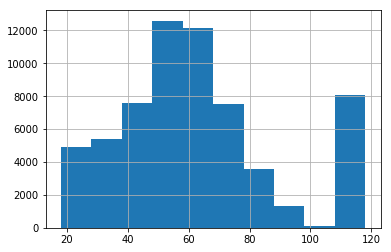

In [1280]:
offers['age'].hist()

In [1281]:
offers.isnull().sum().sort_values(ascending=False)

income                      8066
gender                      8066
membership_tenure_days         0
offer_type_informational       0
offer_type_discount            0
offer_type_bogo                0
social                         0
mobile                         0
email                          0
web                            0
age                            0
duration                       0
difficulty                     0
effective_offer                0
amount                         0
person                         0
dtype: int64

In [1282]:
offers[['age','gender','income']][offers['income'].isnull()].head()
#we can see that the age is not useful in the cases where gender and income are null. Hence, can drop these values

,age,gender,income
5,118,None,NaN
40,118,None,NaN
41,118,None,NaN
42,118,None,NaN
43,118,None,NaN


In [1283]:
offers.dropna(axis=0,inplace=True)

In [1284]:
offers=pd.concat([offers[:],pd.get_dummies(offers['gender'],prefix='gender')],axis=1)

In [1285]:
drop_cols('gender',offers).head()

,person,amount,effective_offer,difficulty,duration,age,income,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational,membership_tenure_days,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,0.00,0,10,7,33,72000.0,1,1,1,0,0,1,0,506.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,8.57,0,0,4,33,72000.0,1,1,1,0,0,0,1,506.0,0,1,0
2,0009655768c64bdeb2e877511632db8f,22.16,0,0,3,33,72000.0,0,0,0,0,0,0,1,506.0,0,1,0
3,0009655768c64bdeb2e877511632db8f,14.11,1,5,5,33,72000.0,1,1,1,1,1,0,0,506.0,0,1,0
4,0009655768c64bdeb2e877511632db8f,82.76,1,10,10,33,72000.0,1,1,1,1,0,1,0,506.0,0,1,0


In [1286]:
offers.columns

Index(['person', 'amount', 'effective_offer', 'difficulty', 'duration', 'age',
       'income', 'web', 'email', 'mobile', 'social', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational',
       'membership_tenure_days', 'gender_F', 'gender_M', 'gender_O'],
      dtype='object')

In [1287]:
offers['person'].nunique()

14820

In [1288]:
no_offers.nunique()

person               6
amount              20
age                  6
became_member_on     6
gender               2
income               5
dtype: int64

4 individual models - determine demographic types that would respond to each type of offer effectively. 3 types of offers, and one type which does not purchase any at all (only 20 records).

Overall multiclass model - only for effective offers.
Overall model - determine how much someone would spend depending on offer type and demographics.

All in all, 6 total models.

There may be people who viewed and completed offers (effective offers) but no transaction associated.

In [1289]:
offers.head()

,person,amount,effective_offer,difficulty,duration,age,income,web,email,mobile,social,offer_type_bogo,offer_type_discount,offer_type_informational,membership_tenure_days,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,0.00,0,10,7,33,72000.0,1,1,1,0,0,1,0,506.0,0,1,0
1,0009655768c64bdeb2e877511632db8f,8.57,0,0,4,33,72000.0,1,1,1,0,0,0,1,506.0,0,1,0
2,0009655768c64bdeb2e877511632db8f,22.16,0,0,3,33,72000.0,0,0,0,0,0,0,1,506.0,0,1,0
3,0009655768c64bdeb2e877511632db8f,14.11,1,5,5,33,72000.0,1,1,1,1,1,0,0,506.0,0,1,0
4,0009655768c64bdeb2e877511632db8f,82.76,1,10,10,33,72000.0,1,1,1,1,0,1,0,506.0,0,1,0


In [1290]:
len(offers[offers['effective_offer']==1])/len(offers)

0.42553692368983376

In [1679]:
offers_bogo=offers[offers['offer_type_bogo']==1].copy()
offers_discount=offers[offers['offer_type_discount']==1].copy()
offers_info=offers[offers['offer_type_informational']==1].copy()

In [1622]:
offers.loc[offers['offer_type_bogo'] == 1, 'type'] =0
offers.loc[offers['offer_type_discount'] == 1, 'type'] =1
offers.loc[offers['offer_type_informational'] == 1, 'type'] =2

Model 1: Determine what are the drivers of effectiveness of bogo type offers

In [1653]:
def data_prep(df):
    drop_cols_offer=['type','amount','offer_type_discount','offer_type_informational','offer_type_bogo']
    drop_cols(drop_cols_offer,df)
    #drop duplicates
    df.drop_duplicates(subset='person',inplace=True)
    # Split the data into features and target label
    drop_cols_offer=['person','effective_offer']
    target = df['effective_offer']
    features = drop_cols(drop_cols_offer,df)
    return features,target

In [1654]:
def model_pipeline(df):
    features,target=data_prep(df)
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)
    #fit and transform training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #transform test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [1655]:
X_train, X_test, y_train, y_test=model_pipeline(offers_bogo)

In [1660]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #Compute accuracy on the first 300 training samples
    results['mse_train'] = mean_squared_error(y_train[:300],predictions_train)
    
    #Compute accuracy on test set
    results['mse_test'] = mean_squared_error(y_test,predictions_test)
    
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    print("MSE_train: %.4f" % results['mse_train'])
    print("MSE_test: %.4f" % results['mse_test'])
    print("Training score:%.4f" % learner.score(X_train,y_train))
    print("Test score:%.4f" % learner.score(X_test,y_test))
    return results

In [1663]:
X_train, X_test, y_train, y_test=model_pipeline(offers_discount)

In [1665]:
def run_model(clf1,clf2):
    # Calculate the number of samples for 1% and 100% of the training data
    samples_100 = len(y_train)
    samples_1 = int(0.01*len(y_train))

    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__
        results[clf_name] = {}
        for i, samples in enumerate([samples_1, samples_100]):
            results[clf_name][i] = \
            train_predict(clf, samples, X_train, y_train, X_test, y_test)

In [1666]:
#Initialize the model
clf1 = svm.SVC(C= 0.1, gamma= 0.001, kernel= 'rbf')
clf2 = RandomForestClassifier(max_depth= 5, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

run_model(clf1,clf2)

SVC trained on 104 samples.
MSE_train: 0.4867
MSE_test: 0.5140
Training score:0.4793
Test score:0.4860
SVC trained on 10433 samples.
MSE_train: 0.2400
MSE_test: 0.3093
Training score:0.6854
Test score:0.6907
RandomForestClassifier trained on 104 samples.
MSE_train: 0.2600
MSE_test: 0.3369
Training score:0.6846
Test score:0.6631
RandomForestClassifier trained on 10433 samples.
MSE_train: 0.2200
MSE_test: 0.2729
Training score:0.7299
Test score:0.7271


In [1667]:
#Initialize the model
clf1 = LogisticRegression(penalty='l1')
clf2 = RandomForestClassifier(max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=20,min_samples_leaf=10)
run_model(clf1,clf2)

LogisticRegression trained on 104 samples.
MSE_train: 0.2800
MSE_test: 0.3135
Training score:0.6880
Test score:0.6865
LogisticRegression trained on 10433 samples.
MSE_train: 0.2367
MSE_test: 0.2867
Training score:0.7147
Test score:0.7133
RandomForestClassifier trained on 104 samples.
MSE_train: 0.2700
MSE_test: 0.3427
Training score:0.6726
Test score:0.6573
RandomForestClassifier trained on 10433 samples.
MSE_train: 0.1700
MSE_test: 0.2664
Training score:0.7623
Test score:0.7336


In [1668]:
#Initialize the model
clf1 = LogisticRegression(penalty='l1')
clf2 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state=2,min_samples_split=100),n_estimators=10)
run_model(clf1,clf2)

LogisticRegression trained on 104 samples.
MSE_train: 0.2800
MSE_test: 0.3135
Training score:0.6879
Test score:0.6865
LogisticRegression trained on 10433 samples.
MSE_train: 0.2367
MSE_test: 0.2867
Training score:0.7147
Test score:0.7133
AdaBoostClassifier trained on 104 samples.
MSE_train: 0.2500
MSE_test: 0.3442
Training score:0.6718
Test score:0.6558
AdaBoostClassifier trained on 10433 samples.
MSE_train: 0.1367
MSE_test: 0.3066
Training score:0.8066
Test score:0.6934


In [1669]:
#Initialize the model
clf1 = LogisticRegression(penalty='l1')
clf2 = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)

run_model(clf1,clf2)

LogisticRegression trained on 104 samples.
MSE_train: 0.2800
MSE_test: 0.3135
Training score:0.6879
Test score:0.6865
LogisticRegression trained on 10433 samples.
MSE_train: 0.2367
MSE_test: 0.2867
Training score:0.7147
Test score:0.7133
DecisionTreeClassifier trained on 104 samples.
MSE_train: 0.4067
MSE_test: 0.4404
Training score:0.5699
Test score:0.5596
DecisionTreeClassifier trained on 10433 samples.
MSE_train: 0.2200
MSE_test: 0.2729
Training score:0.7325
Test score:0.7271


In [1670]:
#Initialize the model
clf1 = LogisticRegression(penalty='l2',C=0.8)
clf2 = XGBClassifier(max_depth=6,n_estimators=15,gamma=0.01,seed=2,learning_rate=0.2)

run_model(clf1,clf2)

LogisticRegression trained on 104 samples.
MSE_train: 0.2767
MSE_test: 0.3212
Training score:0.6870
Test score:0.6788
LogisticRegression trained on 10433 samples.
MSE_train: 0.2367
MSE_test: 0.2871
Training score:0.7146
Test score:0.7129
XGBClassifier trained on 104 samples.
MSE_train: 0.1900
MSE_test: 0.3480
Training score:0.6690
Test score:0.6520


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

XGBClassifier trained on 10433 samples.
MSE_train: 0.1767
MSE_test: 0.2679
Training score:0.7646
Test score:0.7321


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [1671]:
X_train, X_test, y_train, y_test=model_pipeline(offers_info)

In [1675]:
#Initialize the model
clf1 = svm.SVC(C= 0.1, gamma= 0.001, kernel= 'rbf')
clf2 = RandomForestClassifier(max_depth= 5, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

run_model(clf1,clf2)

ValueError: The number of classes has to be greater than one; got 1

In [1089]:
# def svc_param_selection(X, y):
#     Cs = [0.001, 0.01, 0.1, 1, 10]
#     gammas = [0.001, 0.01, 0.1, 1]
#     kernel=['poly','rbf','linear','sigmoid']
#     param_grid = {'C': Cs, 'gamma' : gammas,'kernel': kernel}
#     grid_search = GridSearchCV(svm.SVC(random_state=2), param_grid)
#     grid_search.fit(X, y)
#     grid_search.best_params_
#     return grid_search.best_params_

In [1458]:
# def rand_forest_param_selection(X,y):
#     param_grid={'max_features': ['auto', 'sqrt'],
#                 'max_depth' : [5,10],
#                 'n_estimators': [20, 30, 40],
#                 'min_samples_split': [2, 10, 20],
#                 }
#     grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
#     grid_search.fit(X, y)
#     grid_search.best_params_
#     return grid_search.best_params_
# rand_forest_param_selection(X_train[:samples_1], y_train[:samples_1])